In [3]:
%pip install sortedcontainers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
from functools import cmp_to_key
import numpy as np
import random
from sortedcontainers import SortedList

In [5]:
def orientation(p, q, r):
    """
    Determina a orientação do trio ordenado (p, q, r).
    Se o resultado for 0, então colinear
    Se for 1, então horário
    Se for -1, então anti-horário
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1


def on_segment(p, q, r):
    """
    Verifica se o ponto q está no segmento pr
    """
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and 
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))


In [6]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False

    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

class Event:
    def __init__(self, x, y, segment, is_start, poligono):
        self.x = x
        self.y = y
        self.segment = segment
        self.is_start = is_start
        self.poligono = poligono

    def __lt__(self, other):
        if self.x != other.x:
            return self.x < other.x
        return self.y < other.y

In [7]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            if p1.distancia_ao_quadrado(p0) < p2.distancia_ao_quadrado(p0):
                return -1
            else:
                return 1
        return 1 if o > 0 else -1
    return compare


In [8]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        # Enquanto a orientação não for anti-horária, remova o último ponto
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    # Fechar a envoltória
    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


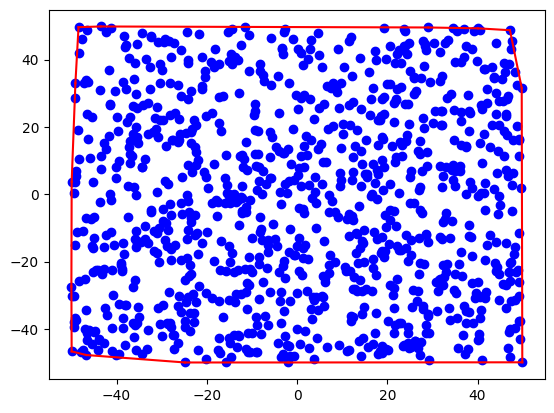

In [9]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)

In [10]:
def cruzam(seg1, seg2):
    """ Verifica se os segmentos seg1 e seg2 se cruzam """
    # Usa sua função 'intersecao' já definida anteriormente
    return seg1.intersecao(seg2)

def segmentos_que_se_cruzam(segmentos, poligonos):
    # Mapeamento de segmentos para seus polígonos
    segmento_para_poligono = {seg: pol for seg, pol in zip(segmentos, poligonos)}
    
    # Criar eventos
    eventos = []
    for seg in segmentos:
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg))
        eventos.append((end, 'end', seg))
    
    # Ordenar eventos
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    active_segments = SortedList(key=lambda s: (s.p1.y + s.p2.y) / 2)
    intersecoes = set()

    # Processar eventos
    for ponto, tipo, segmento in eventos:
        if tipo == 'start':
            idx = active_segments.bisect(segmento)
            
            # Verificar interseção com segmento abaixo
            if idx > 0 and segmento.intersecao(active_segments[idx - 1]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx - 1]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx - 1]])))

            # Verificar interseção com segmento acima
            if idx < len(active_segments) and segmento.intersecao(active_segments[idx]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx]])))

            active_segments.add(segmento)
        else:
            if segmento in active_segments:
                segmento_idx = active_segments.index(segmento)
                
                # Verificar interseção entre segmentos vizinhos
                if 0 < segmento_idx < len(active_segments) - 1:
                    seg_below = active_segments[segmento_idx - 1]
                    seg_above = active_segments[segmento_idx + 1]
                    if seg_below.intersecao(seg_above) and segmento_para_poligono[seg_below] != segmento_para_poligono[seg_above]:
                        intersecoes.add(tuple(sorted([seg_below, seg_above])))
                
                active_segments.remove(segmento)
    
    return list(intersecoes)


In [11]:
def verificar_separabilidade_linear(classe_1, classe_2):
    envoltoria_classe_1 = graham_scan(classe_1)
    envoltoria_classe_2 = graham_scan(classe_2)

    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    todos_os_segmentos = segmentos_classe_1 + segmentos_classe_2
    poligonos = [1] * len(segmentos_classe_1) + [2] * len(segmentos_classe_2)

    intersecoes = segmentos_que_se_cruzam(todos_os_segmentos, poligonos)
    return len(intersecoes) == 0


In [12]:
def plot_separabilidade(classe_1, classe_2):

    classe_1 = graham_scan(classe_1)
    classe_2 = graham_scan(classe_2)
    print(classe_1)
    print(classe_2)

    # Verificar se os dados são linearmente separáveis
    separaveis = verificar_separabilidade_linear(classe_1, classe_2)
    
    # Plotar envoltória da classe 1
    for i in range(len(classe_1) - 1):
        plt.plot([classe_1[i].x, classe_1[i + 1].x], 
                 [classe_1[i].y, classe_1[i + 1].y], 'b-')
    
    # Plotar envoltória da classe 2
    for i in range(len(classe_2) - 1):
        plt.plot([classe_2[i].x, classe_2[i + 1].x], 
                 [classe_2[i].y, classe_2[i + 1].y], 'r-')
    
    if separaveis:
        plt.title("Dados são linearmente separáveis!")
    else:
        plt.title("Dados não são linearmente separáveis!")
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

[(7, 1), (7, 4), (2, 6), (7, 1)]
[(5, 8), (13, 9), (7, 10), (5, 8)]


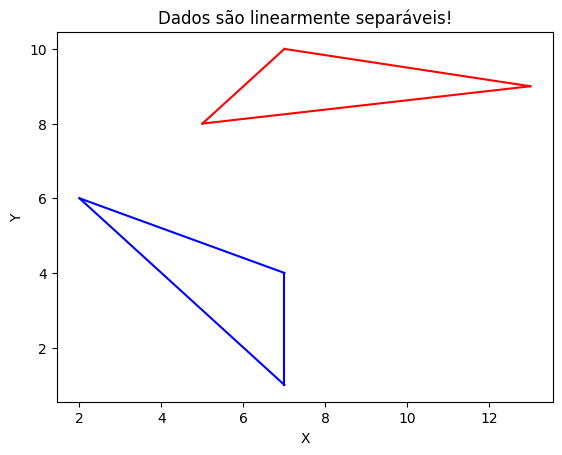

In [13]:
# Gerar pontos aleatórios para ambas as classes
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(3)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(3)]

plot_separabilidade(classe_1_random, classe_2_random)

In [14]:
def encontrar_pontos_mais_proximos(env1, env2):
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for p1 in env1:
        for p2 in env2:
            distancia = p1.distancia_ao_quadrado(p2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = p1
                ponto2 = p2

    return ponto1, ponto2

def construir_modelo_linear(pontos1, pontos2):
    env1 = graham_scan(pontos1)
    env2 = graham_scan(pontos2)

    if not verificar_separabilidade_linear(env1, env2):
        print('Os dados não são linearmente separáveis.')
        return None

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)

    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    if vetor_direcao_perpendicular.x == 0:
        return 'vertical', ponto_medio.x, env1, env2
    else:
        m = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
        b = ponto_medio.y - m * ponto_medio.x
        return m, b, env1, env2

def plot_modelo(pontos1, pontos2):
    resultado = construir_modelo_linear(pontos1, pontos2)

    if resultado is None:
        return None
    
    modelo, b, env1, env2 = resultado

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)
    plt.fill([p.x for p in env1], [p.y for p in env1], color='blue', alpha=0.3)
    plt.fill([p.x for p in env2], [p.y for p in env2], color='red', alpha=0.3)
    plt.plot([p.x for p in env1 + [env1[0]]], [p.y for p in env1 + [env1[0]]], 'b-')
    plt.plot([p.x for p in env2 + [env2[0]]], [p.y for p in env2 + [env2[0]]], 'r-')
    plt.plot([ponto1.x, ponto2.x], [ponto1.y, ponto2.y], 'g--')
    
    if modelo == 'vertical':
        plt.axvline(x=b, color='c', label='Modelo Linear')
    else:
        m = modelo
        x_vals = [min([p.x for p in env1 + env2]), max([p.x for p in env1 + env2])]
        y_vals = [m*x+b for x in x_vals]
        plt.plot(x_vals, y_vals, 'c-', label='Modelo Linear')

    plt.legend()
    plt.show()


In [15]:
# Gerar pontos aleatórios para testar
classe_1 = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(5)]
classe_2 = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(5)]

plot_modelo(classe_1, classe_2)

Os dados não são linearmente separáveis.


In [18]:
def classificar_pontos(pontos1, pontos2, modelo):
    """
    Classifica pontos com base no modelo e retorna duas listas separadas.
    
    :param pontos1: Lista de pontos da primeira classe.
    :param pontos2: Lista de pontos da segunda classe.
    :param modelo: Modelo linear obtido pela função construir_modelo_linear.
    :return: Duas listas de pontos classificados para cada classe.
    """
    classificados_classe1 = []
    classificados_classe2 = []

    # Classificar pontos da primeira lista
    for p in pontos1:
        if modelo[0] == 'vertical':
            if p.x <= modelo[1]:
                classificados_classe1.append(p)
            else:
                classificados_classe2.append(p)
        else:
            y_modelo = modelo[0] * p.x + modelo[1]
            if p.y <= y_modelo:
                classificados_classe1.append(p)
            else:
                classificados_classe2.append(p)

    # Classificar pontos da segunda lista
    for p in pontos2:
        if modelo[0] == 'vertical':
            if p.x > modelo[1]:
                classificados_classe2.append(p)
            else:
                classificados_classe1.append(p)
        else:
            y_modelo = modelo[0] * p.x + modelo[1]
            if p.y > y_modelo:
                classificados_classe2.append(p)
            else:
                classificados_classe1.append(p)

    return classificados_classe1, classificados_classe2

def plotar_classificacao(pontos1, pontos2, modelo):
    """
    Plota os pontos e a reta do modelo.
    
    :param pontos1: Lista de pontos da primeira classe.
    :param pontos2: Lista de pontos da segunda classe.
    :param modelo: Modelo linear obtido pela função construir_modelo_linear.
    """
    # Extrair coordenadas x e y dos pontos para plotagem
    x1, y1 = zip(*[(p.x, p.y) for p in pontos1])
    x2, y2 = zip(*[(p.x, p.y) for p in pontos2])
    
    # Plotar os pontos
    plt.scatter(x1, y1, color='blue', label='Classe 1')
    plt.scatter(x2, y2, color='red', label='Classe 2')
    
    # Plotar a reta do modelo
    if modelo[0] == 'vertical':
        plt.axvline(x=modelo[1], color='green', linestyle='--', label='Reta do Modelo')
    else:
        # Criando uma sequência de valores x para a reta
        x_reta = list(range(int(min(x1 + x2)) - 1, int(max(x1 + x2)) + 2))
        y_reta = [modelo[0] * x + modelo[1] for x in x_reta]
        
        plt.plot(x_reta, y_reta, color='green', linestyle='--', label='Reta do Modelo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Classificação de Pontos com Modelo Linear')
    plt.grid(True)
    plt.show()

Classe 1: [(3.3827158151458843, 1.425609690636146), (3.525231037462786, 4.676078041595223), (3.536259305537925, 4.185160360430454), (1.403341069184808, 4.643409875401364), (2.969897436779469, 4.051010158432662), (0.4952375204751469, 0.6998474771633101), (1.261043688297962, 2.034775167068357), (1.5023754588518623, 3.7177335000779026), (0.07310612981741293, 4.126170118594279), (3.9078785282651953, 1.3220583015866716), (2.8483139881742554, 4.565477346842802), (4.318401173669359, 4.612889303646358), (1.251641843874044, 3.9306041270131242), (2.4632516610024746, 0.3247039414660863), (1.8951936171609507, 3.0159593768924338), (4.982691222604029, 2.820735190754478), (2.905331872063636, 4.198615000332525), (3.641977177242021, 3.4367173807238793), (2.0748565462207624, 1.7939570042552655), (4.935555145918958, 0.48042765167547186), (2.7289835573870755, 2.883588039291266), (1.9638128982121366, 2.9717793767045486), (0.601896656133471, 1.4058227206661038), (1.5056244401666867, 1.1983935371182635), (1.

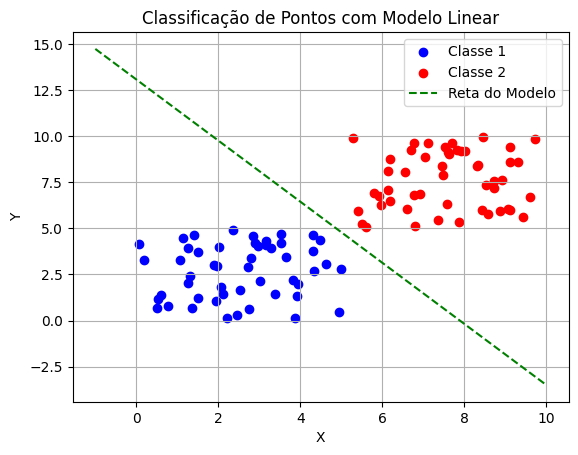

In [19]:
def gerar_pontos_aleatorios(qtd_pontos, limite_inf, limite_sup):
    """
    Gera uma lista de pontos aleatórios.
    
    :param qtd_pontos: Número de pontos a serem gerados.
    :param limite_inf: Tuple contendo os limites inferiores (x, y).
    :param limite_sup: Tuple contendo os limites superiores (x, y).
    :return: Lista de pontos aleatórios.
    """
    pontos = []
    for _ in range(qtd_pontos):
        x = random.uniform(limite_inf[0], limite_sup[0])
        y = random.uniform(limite_inf[1], limite_sup[1])
        pontos.append(Ponto(x, y))
    return pontos

# Exemplo de uso:
pontos1_aleatorios = gerar_pontos_aleatorios(50, (0, 0), (5, 5))
pontos2_aleatorios = gerar_pontos_aleatorios(50, (5, 5), (10, 10))
modelo = construir_modelo_linear(pontos1_aleatorios, pontos2_aleatorios)

if modelo:
    classe1, classe2 = classificar_pontos(pontos1_aleatorios, pontos2_aleatorios, modelo)
    print(f'Classe 1: {classe1}')
    print(f'Classe 2: {classe2}')
    plotar_classificacao(pontos1_aleatorios, pontos2_aleatorios, modelo)